<a href="https://colab.research.google.com/github/karolinabnk/MLproject_for_shelter/blob/master/Shelter_project_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0 Imports & loading data

In [1]:
import numpy as np 
import pandas as pd
from google.colab import files
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
df = pd.read_csv('train.csv')

##1 Data preprocessing 

###1.1 Mapping, deleting unnecessary features and missing values, getting dummies

In [4]:
df = df.drop(['AnimalID','Name', 'DateTime','OutcomeSubtype','Color'], axis=1)
df = df.dropna()


In [5]:
def switch_age(argument):
    words = argument.split()
    #unit = re.sub("s", "", words[1])
    if(words[0]=='nan'):
      return 
    multiplayer = int(words[0])
    switcher = {
        'day' : 1,
        'days' : 1,
        'week' : 7,
        'weeks' : 7,
        'month' : 30,
        'months' : 30,
        'year' : 365,
        'years': 365
    }
    return multiplayer * switcher.get(words[1], 0)

df['AgeuponOutcome'] = df['AgeuponOutcome'].astype(str)
df['AgeuponOutcome'] = df['AgeuponOutcome'].map(switch_age)

In [6]:
outcome_mapping = {label:idx for idx,label in enumerate(df['OutcomeType'].unique())}
df['OutcomeType'] = df['OutcomeType'].map(outcome_mapping)

In [7]:
sex_mapping = {label:idx for idx,label in enumerate(df['SexuponOutcome'].unique())}
df['SexuponOutcome'] = df['SexuponOutcome'].map(sex_mapping)

sex2 = df['SexuponOutcome'].copy()
df['Neutred/Spayed'] = sex2

In [8]:
sex_bin_mapping = {0:'male',1:'female',2:'male',3:'female',4:'unknown'}    
neutred_mapping = {0:'neutred',1:'neutred',2:'intact',3:'intact',4:'intact'}

df['SexuponOutcome'] = df['SexuponOutcome'].map(sex_bin_mapping)
df['Neutred/Spayed'] = df['Neutred/Spayed'].map(neutred_mapping)


In [9]:
df['IsMix'] = df['Breed'].str.contains('mix',case=False)
df = df.drop(['Breed'],axis=1)

is_mix_to_string = {True:'mix', False:'notmix'}
df['IsMix'] = df['IsMix'].map(is_mix_to_string)
df = pd.get_dummies(df)

###1.2 Dividing, standarization

In [10]:
X = df.loc[:,'AgeuponOutcome':'IsMix_notmix']
y = df['OutcomeType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) #Setting random_state a fixed value will guarantee that same sequence of random numbers are generated each time you run the code.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std=scaler.transform(X_test)


###1.3 Making one additional vector only for adoption outcome

In [11]:
outcome_mapping

{'Adoption': 2,
 'Died': 4,
 'Euthanasia': 1,
 'Return_to_owner': 0,
 'Transfer': 3}

In [12]:
adopt_map = {2:1,4:0,1:0,0:0,3:0}
y_adopt_train = y_train.map(adopt_map)
y_adopt_test = y_test.map(adopt_map)

#2. Different models evaluation


###2.1 K nearest neighbours



In [13]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)
knn.fit(X_train_std,y_train)
y_pred_knn = knn.predict(X_test_std)
print('Accuracy: %3f' %accuracy_score(y_test,y_pred_knn))
print('F1: %3f' %f1_score(y_test,y_pred_knn,average='micro'))
print('F1 for predicting adoption: %3f' %f1_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_knn),average="weighted" ))

Accuracy: 0.567952
F1: 0.567952
F1 for predicting adoption: 0.711961


###2.2 Kernel SVM

In [14]:
svc = svm.SVC(kernel='poly', degree=4, C=1.0, random_state = 0)
svc.fit(X_train_std,y_train)
y_pred_svc = svc.predict(X_test_std)

print('Accuracy score: %3f' %accuracy_score(y_test, y_pred_svc))
print('F1: %3f' %f1_score(y_test,y_pred_svc,average='micro'))
print('F1 for predicting adoption: %3f' %f1_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_svc)))


Accuracy score: 0.630351
F1: 0.630351
F1 for predicting adoption: 0.723652


In [15]:
clf = svm.SVC()
scorer = make_scorer(f1_score,average='micro')
grid_values = {'kernel': ['poly','rbf'], 'degree':[3,4,5], 'C':[0.001,0.01,1]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring=scorer)
grid_clf.fit(X_train_std,y_train)
print(grid_clf.best_score_)
print(grid_clf.best_params_)

0.630957017590279
{'C': 1, 'degree': 5, 'kernel': 'poly'}


###2.3 Decision tree & random forest

In [16]:
tree = DecisionTreeClassifier(criterion='gini', random_state=0)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print('Accuracy score: %2f' %accuracy_score(y_test, y_pred_tree))
print('F1: %3f' %f1_score(y_test,y_pred_tree,average = 'micro'))
print('F1 for predicting adoption: %3f' %f1_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_tree) ))
#pre_scorer = make_scorer(score_func=f1_score,pos_label=1,greater_is_better=True, average='micro')

Accuracy score: 0.629727
F1: 0.629727
F1 for predicting adoption: 0.719636


In [17]:
forest = RandomForestClassifier(criterion='gini', n_estimators=1000, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

print('Accuracy score: %2f' %accuracy_score(y_test, y_pred_forest))
print('F1: %3f' %f1_score(y_test,y_pred_forest,average = 'micro'))
print('F1 for predicting adoption: %3f' %f1_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_forest) ))

Accuracy score: 0.630975
F1: 0.630975
F1 for predicting adoption: 0.721460


###2.4 XGBoost

In [18]:
xgb_clas = xgb.XGBClassifier()
xgb_clas.fit(X_train,y_train)
y_pred_xgb = xgb_clas.predict(X_test)
print('Accuracy score: %2f' %accuracy_score(y_test, y_pred_xgb))
print('F1: %3f' %f1_score(y_test,y_pred_xgb,average = 'micro'))
print('F1 for predicting adoption: %3f' %f1_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_xgb) ))

Accuracy score: 0.630351
F1: 0.630351
F1 for predicting adoption: 0.720457


In [19]:
skf = StratifiedKFold(n_splits=15, random_state=1)
skf.get_n_splits(X_train, y_train)
k=0
scores=[]

for train, test in skf.split(X_train,y_train):
  k=k+1
  xgb_clas.fit(X_train.iloc[train],y_train.iloc[train])
  preds = xgb_clas.predict(X_train.iloc[test])
  score = f1_score(preds,y_train.iloc[test],average='micro') #xgb_clas.score(X_train[test], y_train.iloc[test])
  score2 = f1_score (y_train.iloc[test].map(adopt_map),np.vectorize(adopt_map.get)(preds) )
  scores.append(score)
  print('Fold: %s, Prec: %.3f, Prec. for adoption: %3f' % (k, score,score2))

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold: 1, Prec: 0.633, Prec. for adoption: 0.709565
Fold: 2, Prec: 0.633, Prec. for adoption: 0.705680
Fold: 3, Prec: 0.635, Prec. for adoption: 0.728033
Fold: 4, Prec: 0.625, Prec. for adoption: 0.716239
Fold: 5, Prec: 0.650, Prec. for adoption: 0.735319
Fold: 6, Prec: 0.640, Prec. for adoption: 0.747253
Fold: 7, Prec: 0.646, Prec. for adoption: 0.725862
Fold: 8, Prec: 0.648, Prec. for adoption: 0.738033
Fold: 9, Prec: 0.637, Prec. for adoption: 0.729131
Fold: 10, Prec: 0.658, Prec. for adoption: 0.750427
Fold: 11, Prec: 0.616, Prec. for adoption: 0.709677
Fold: 12, Prec: 0.638, Prec. for adoption: 0.742475
Fold: 13, Prec: 0.622, Prec. for adoption: 0.704082
Fold: 14, Prec: 0.615, Prec. for adoption: 0.698492
Fold: 15, Prec: 0.628, Prec. for adoption: 0.723695
CV accuracy: 0.635 +/- 0.012


In [20]:
preds = xgb_clas.predict(X_test)
print('Accuracy score: %2f' %accuracy_score(y_test, preds))
print('F1: %3f' %f1_score(y_test,preds,average = 'micro'))
print('F1 for predicting adoption: %3f' %f1_score (y_adopt_test,np.vectorize(adopt_map.get)(preds) ))

Accuracy score: 0.628728
F1: 0.628728
F1 for predicting adoption: 0.719663


In [21]:
clf=xgb.XGBClassifier()
scorer = make_scorer(f1_score,average='micro')
grid_values = {'max_depth':[3,5,10], 'learning_rate':[0.1,0.5,1], 'n_estimators':[10,50,100,500]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring=scorer)
grid_clf.fit(X_train,y_train)
print(grid_clf.best_score_)
print(grid_clf.best_params_)

0.6381771985703518
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


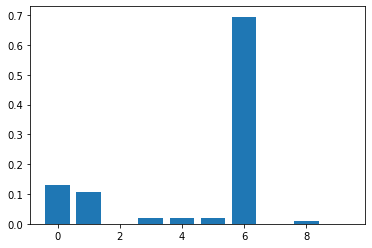

In [22]:
clf.fit(X_train,y_train)
pyplot.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
pyplot.show()


In [23]:
df.head()

,OutcomeType,AgeuponOutcome,AnimalType_Cat,AnimalType_Dog,SexuponOutcome_female,SexuponOutcome_male,SexuponOutcome_unknown,Neutred/Spayed_intact,Neutred/Spayed_neutred,IsMix_mix,IsMix_notmix
0,0,365,0,1,0,1,0,0,1,1,0
1,1,365,1,0,1,0,0,0,1,1,0
2,2,730,0,1,0,1,0,0,1,1,0
3,3,21,1,0,0,1,0,1,0,1,0
4,3,730,0,1,0,1,0,0,1,0,1
